In [1]:
import os
import re
from collections import defaultdict
import math
import random
import pandas as pd
import numpy as np

import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as F
from torchvision.io import read_image

In [2]:
seed = 281

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [3]:
class MavocDataset(Dataset):
    """MAVOC dataset containing pairs of EO + SAR images"""

    def __init__(self, root_dir, eo_transform=None, sar_transform=None, composite_transform=None):
        """
        Constructs a dataframe reference to each sample pair and label in the MAVOC "training" dataset
        :param root_dir (string): path to the folder containing the class folders
        :param transform (callable, optional): transforms to be applied on paired EO + SAR samples
        """

        self.root_dir = root_dir
        self.img_pairs = defaultdict(lambda: dict)

        self.eo_transform = eo_transform
        self.sar_transform = sar_transform
        self.composite_transform = composite_transform

        eo_prefix = "EO" # case sensitive!
        sar_prefix = "SAR"
        class_folders = os.listdir(self.root_dir)
        if '.DS_Store' in class_folders: class_folders.remove('.DS_Store') # for macOS

        # populate a dictionary with image_id number, the eo and sar file path, and class label
        for class_dir in class_folders:
            for file in os.listdir(os.path.join(self.root_dir, class_dir)):

                id = int(re.findall("\d+", file)[0]) # grab the integer (image_id) in filename and use as key
                label = int(class_dir)
                img_path = os.path.join(self.root_dir,class_dir, file)

                if id in self.img_pairs.keys():
                    if file.startswith(eo_prefix):
                        self.img_pairs[id].update({"eo_img": img_path})
                    if file.startswith(sar_prefix):
                        self.img_pairs[id].update({"sar_img": img_path})
                else:
                    if file.startswith(eo_prefix):
                        self.img_pairs[id] = {"eo_img": img_path, "sar_img":None, "label":label}
                    if file.startswith(sar_prefix):
                        self.img_pairs[id] = {"eo_img": None,"sar_img": img_path, "label":label}

        # convert the dict to a dataframe so that we can properly index into the dataset with __getitem__
        self.img_labels_df = pd.DataFrame.from_dict(self.img_pairs, orient='index')
        self.img_labels_df.reset_index(inplace=True)
        self.img_labels_df = self.img_labels_df.rename(columns = {'index':'image_id'})

    def __getitem__(self, idx):
        df = self.img_labels_df
        eo_img_path = df.loc[df.index[idx], "eo_img"]
        sar_img_path = df.loc[df.index[idx], "sar_img"]

        eo_image = read_image(eo_img_path) # reads jpeg or png into a 3d RGB or grayscale tensor (uint8 in [0,255])
        sar_image = read_image(sar_img_path)
        # composite_image = None

        # resize EO to 31x31
        eo_image = F.resize(eo_image, (31, 31))
        # resize SAR to 55x55 (slightly vary in size)
        sar_image = F.resize(sar_image, (55, 55))

        if self.eo_transform:
            eo_image = self.eo_transform(eo_image)
        if self.sar_transform:
            sar_image = self.sar_transform(sar_image)

        # TODO: add composite_image to return statement
        # if self.composite_transform:
        #     composite_image = self.composite_transform(eo_image, sar_image)

        label = df.loc[df.index[idx], "label"]

        return eo_image, sar_image, label

    def __len__(self):
        return len(self.img_labels_df.index)

In [4]:
dataset = MavocDataset(root_dir="data/train", eo_transform=None, sar_transform=None)

In [5]:
eo_feature, sar_feature, sample_label = dataset[0]

torch.Size([1, 31, 31])


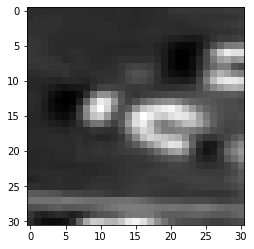

In [6]:
print(eo_feature.shape)
plt.imshow(eo_feature.permute(1, 2, 0), cmap="gray") # torch tensor's first dim is the channel dim. So need to reshape it for plotting

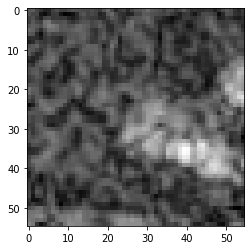

In [7]:
plt.imshow(sar_feature.permute(1, 2, 0), cmap="gray")

In [8]:
batch_size = 4
dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True, num_workers=0)

# checking sample by sample
dataiter = iter(dataloader)
data = dataiter.next()
eo_feats, sar_feats, labels = data

print(f"Example with batch size:{batch_size}")
print(f"EO Features:\n{eo_feats} \n, SAR Features:\n{sar_feats} \n, Labels:\n{labels}")

Example with batch size:4
EO Features:
tensor([[[[ 88, 100, 107,  ...,  18,  18,  15],
          [ 94, 106, 106,  ...,  16,  16,  16],
          [105, 114, 108,  ...,  16,  16,  16],
          ...,
          [142, 141, 142,  ...,  56,  57,  55],
          [145, 142, 139,  ...,  56,  55,  56],
          [146, 143, 139,  ...,  57,  57,  58]]],


        [[[ 45,  46,  47,  ...,  68,  68,  68],
          [ 46,  48,  48,  ...,  69,  69,  69],
          [ 48,  49,  49,  ...,  70,  69,  69],
          ...,
          [ 77,  81,  87,  ...,  70,  70,  70],
          [ 88,  90,  90,  ...,  70,  70,  70],
          [ 97,  90,  84,  ...,  70,  70,  69]]],


        [[[ 20,  23,  28,  ...,  78,  88,  89],
          [ 28,  31,  35,  ...,  82,  86,  83],
          [ 34,  36,  40,  ...,  70,  64,  63],
          ...,
          [ 77,  77,  76,  ...,  46,  46,  46],
          [ 75,  75,  75,  ...,  42,  45,  45],
          [ 75,  74,  74,  ...,  42,  45,  46]]],


        [[[ 90,  91,  90,  ...,  63,  64

In [9]:
# Dummy Training loop
num_epochs = 2
total_samples = len(dataset)
n_iterations = math.ceil(total_samples/4)
print(total_samples, n_iterations)
for epoch in range(num_epochs):
    for i, (eo_input, sar_input, labels) in enumerate(dataloader):

        # Run your training process
        if (i+1) % 5 == 0:
            print(f'Epoch: {epoch+1}/{num_epochs}, Step {i+1}/{n_iterations}| EO Inputs {eo_input.shape} | SAR Inputs {sar_input.shape}| Labels {labels.shape}')

293772 73443
Epoch: 1/2, Step 5/73443| EO Inputs torch.Size([4, 1, 31, 31]) | SAR Inputs torch.Size([4, 1, 55, 55])| Labels torch.Size([4])
Epoch: 1/2, Step 10/73443| EO Inputs torch.Size([4, 1, 31, 31]) | SAR Inputs torch.Size([4, 1, 55, 55])| Labels torch.Size([4])
Epoch: 1/2, Step 15/73443| EO Inputs torch.Size([4, 1, 31, 31]) | SAR Inputs torch.Size([4, 1, 55, 55])| Labels torch.Size([4])
Epoch: 1/2, Step 20/73443| EO Inputs torch.Size([4, 1, 31, 31]) | SAR Inputs torch.Size([4, 1, 55, 55])| Labels torch.Size([4])
Epoch: 1/2, Step 25/73443| EO Inputs torch.Size([4, 1, 31, 31]) | SAR Inputs torch.Size([4, 1, 55, 55])| Labels torch.Size([4])
Epoch: 1/2, Step 30/73443| EO Inputs torch.Size([4, 1, 31, 31]) | SAR Inputs torch.Size([4, 1, 55, 55])| Labels torch.Size([4])
Epoch: 1/2, Step 35/73443| EO Inputs torch.Size([4, 1, 31, 31]) | SAR Inputs torch.Size([4, 1, 55, 55])| Labels torch.Size([4])
Epoch: 1/2, Step 40/73443| EO Inputs torch.Size([4, 1, 31, 31]) | SAR Inputs torch.Size([4, 

KeyboardInterrupt: 

Resources:

Pytorch dataset & dataloader video tutorial: [https://www.youtube.com/watch?v=c36lUUr864M&t=7813s](https://www.youtube.com/watch?v=c36lUUr864M&t=7813s)

Pytorch dataset class documentation: [https://pytorch.org/vision/stable/datasets.html](https://pytorch.org/vision/stable/datasets.html)

How to write dataset class for paired images: [https://discuss.pytorch.org/t/how-to-write-the-dataloader-for-pairs-images/43547/2](https://discuss.pytorch.org/t/how-to-write-the-dataloader-for-pairs-images/43547/2)

How torchvision read_image() method works: [https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html#torchvision.io.read_image](https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html#torchvision.io.read_image)
